In [1]:
import os
import sys

from datasets import load_dataset

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import colors
import pretty_midi
import pandas as pd
import IPython.display as ipd
import glob
import numpy as np
import muspy
import pypianoroll
import torch
from util.play_midi import play_midi

from miditok import REMI, TokenizerConfig, Octuple
from miditok.pytorch_data import DatasetMIDI, DataCollator
from pathlib import Path
from symusic import Score
from torch.utils.data import DataLoader

# This uses mido top get lengths and tempos of all songs that can be processed by library
import mido
from mido import MidiFile


In [4]:
#### pre_processing
# os.chdir("..")
print(os.getcwd())
print(os.curdir)

# midi_files = list(Path("nottingham-dataset-master/nottingham-dataset-master/MIDI").glob("*.mid"))
midi_files = list(Path("data/jazz_midi").glob("*.mid"))
print(len(midi_files))

c:\Users\joeac\Documents\Uni\Y3\Project\lofi_radio-1
.
934


In [5]:
print(len(midi_files))
file_counter = file_count_current = len(midi_files)
corrupt_files = []
while True:
    for file in midi_files: # removing corrupted files/ files that cant be fully understood
        try:
            s = Score(file)
        except:
            # corrupt_files.append(midi_files.pop(file))
            file_holder = file
            midi_files.remove(file)
            corrupt_files.append(file_holder)
            
    if file_count_current == len(midi_files):
        break
    file_count_current = len(midi_files)
    print(file_count_current)

# # while True:
# y = []
# for file in midi_files: # removing corrupted files/ files that cant be fully understood
#     try:
#         pm = pretty_midi.PrettyMIDI(file)
#         y.append({'n_instruments': len(pm.instruments),
#                 'program_numbers': [i.program for i in pm.instruments if not i.is_drum],
#                 'key_numbers': [k.key_number for k in pm.key_signature_changes],
#                 'tempos': list(pm.get_tempo_changes()[1]),
#                 'time_signature_changes': pm.time_signature_changes,
#                 'end_time': pm.get_end_time(),
#                 'lyrics': [l.text for l in pm.lyrics]})
#     except:
#             # corrupt_files.append(midi_files.pop(file))
#         file_holder = file
#         midi_files.remove(file)
#         corrupt_files.append(file_holder)
            
# if file_count_current == len(midi_files):
#     break
# file_count_current = len(midi_files)
# print(file_count_current)
    
print(f"corrupt file counter = {len(corrupt_files)} which is {'correct' if file_counter-len(midi_files)==len(corrupt_files) else 'incorrect'}")
file_counter = len(midi_files)

934
914
913
corrupt file counter = 21 which is correct


In [ ]:
play_midi(midi_files[0])

In [7]:
lengths = [] # makes list of legnths and tempos using mido library
files_not_working = []
tempos = []
velocities = np.zeros(128)
pitches = np.zeros(128)
num_of_tracks = []
for file in tqdm(midi_files):
    try:
        s = MidiFile(file)
        num_of_tracks.append(len(s.tracks))
        lengths.append(s.length)
        for msg in s:
            if msg.type == 'set_tempo':
                tempo = mido.tempo2bpm(msg.tempo)
                tempos.append(tempo)
            elif msg.type == "note_on":
                pitches[msg.note] += 1
                if msg.velocity != 0:
                    velocities[msg.velocity] += 1
    except:
        files_not_working.append(file)

# pitch_occurrences = np.zeros(128) # makes list of pitch occurences using symusic library
# for file in tqdm(midi_files):
#     s = Score(file)
#     for track in s.tracks:
#         for notes in track.notes:
#             pitch_occurrences[notes.pitch] += 1
pitch_probabilities = pitches / sum(pitches)


100%|██████████| 913/913 [06:09<00:00,  2.47it/s]


In [12]:
# s = MidiFile(midi_files[1006])
# print(len(s.tracks))
# print(s.tracks)
# s = Score(midi_files[1006])
# print(len(s.tracks))


# fig, ax = plt.subplots()
# ax.hist(pitches, bins=128)    
# ax.set_title("Pitch Distribution")
# ax.set_xlabel("Pitch number")
# ax.set_ylabel("Number of occurences")
# ax.grid(True, linestyle="--")

# plt.show()

# fig, ax = plt.subplots()
# ax.plot(velocities, bins = 128)

# plt.show

num of songs analysed = 911 
7039 tempos in these songs
mean, max, min tracks per song 10.791437980241493, 130, 1
mean, max, min  length = 243.20059151521176, 2798.3683648875062, 6.399999999999995
mean, max, min pitches = 47804.46875, 554199.0, 3.0
mean, max, min velocities = 31482.140625, 465202.0, 0.0


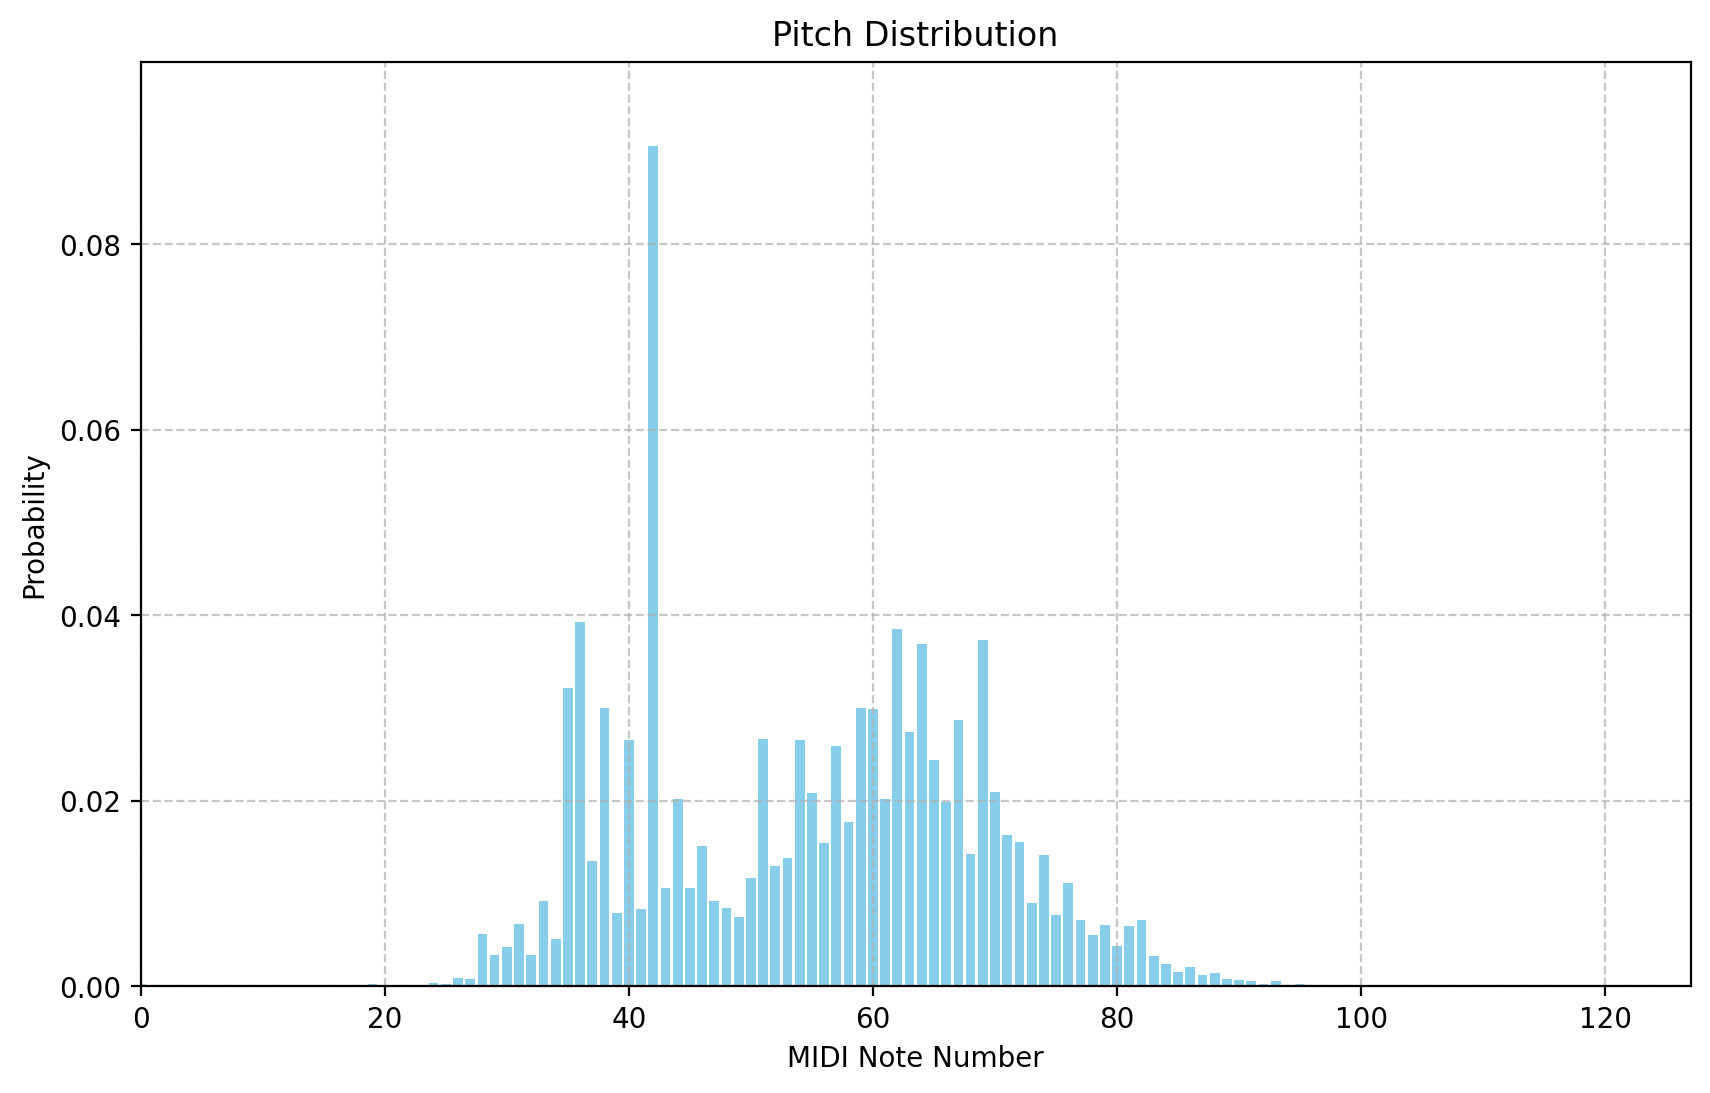

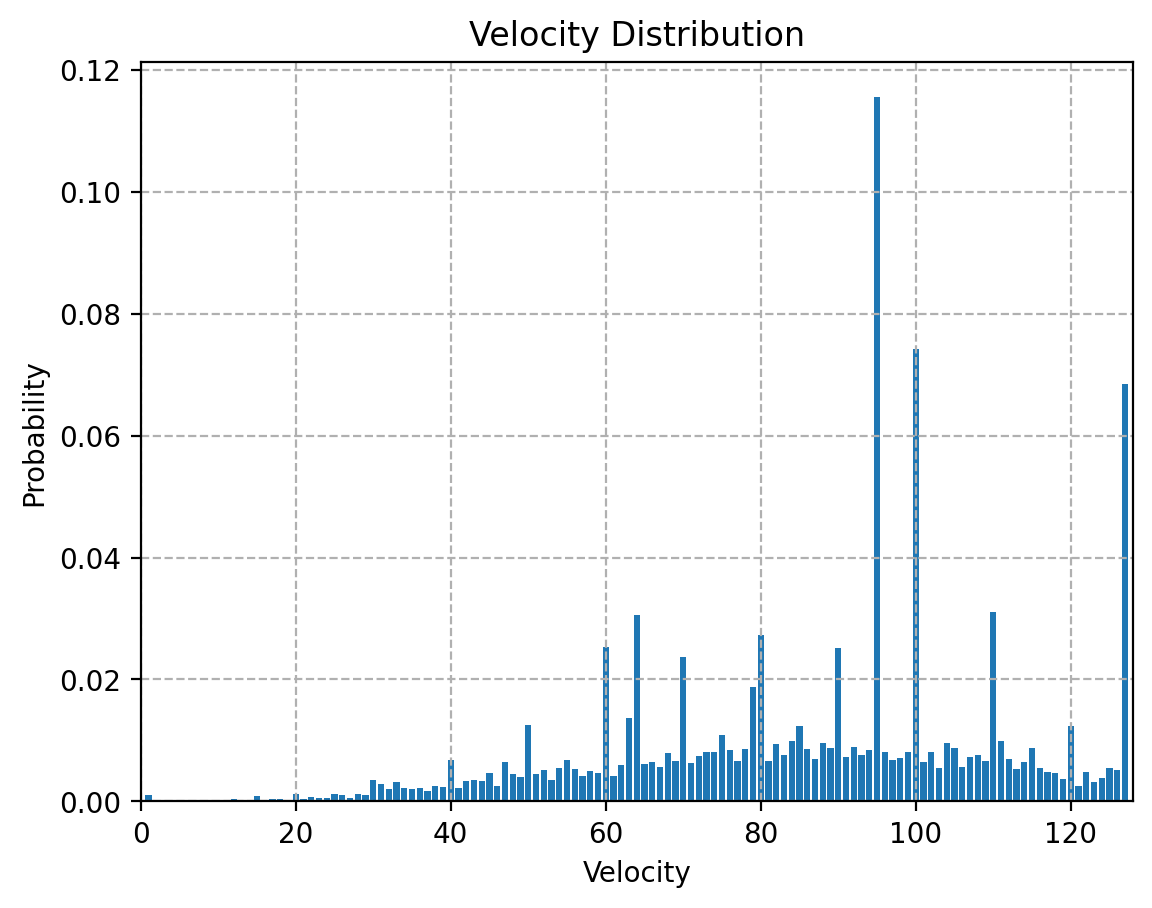

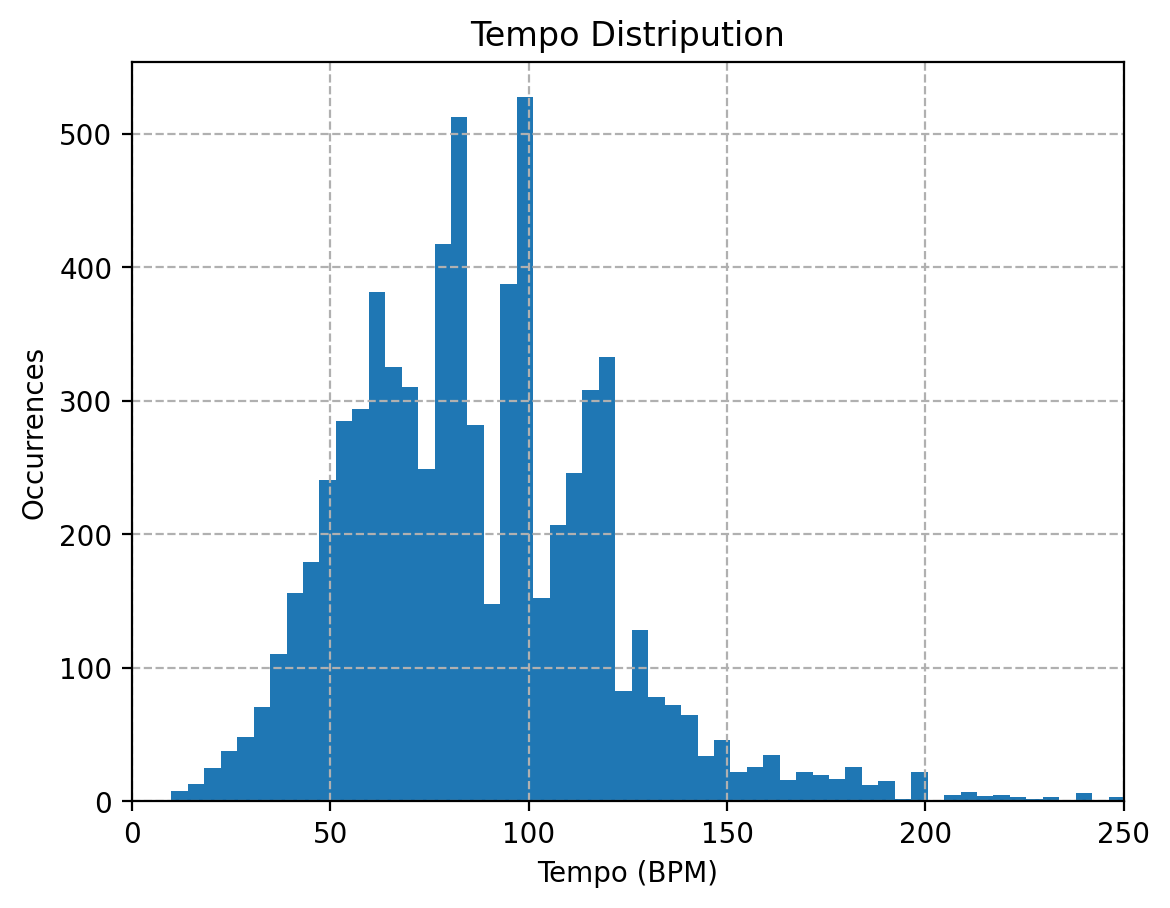

In [15]:
def plot_pitch_distribution(pitch_probabilities):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(pitch_probabilities)), pitch_probabilities, color='skyblue')
    plt.title('Pitch Distribution')
    plt.xlabel('MIDI Note Number')
    plt.ylabel('Probability')
    plt.xlim(0, 127)
    plt.ylim(0, max(pitch_probabilities) * 1.1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

print(f"num of songs analysed = {len(lengths)} \n{len(tempos)} tempos in these songs")
print(f"mean, max, min tracks per song {np.mean(num_of_tracks)}, {max(num_of_tracks)}, {min(num_of_tracks)}")
print(f"mean, max, min  length = {np.mean(lengths)}, {max(lengths)}, {min(lengths)}")
# print(f"mean, max, min tempos = {np.mean(tempos)}, {max(tempos)}, {min(tempos)}")
print(f"mean, max, min pitches = {np.mean(pitches)}, {max(pitches)}, {min(pitches)}")
print(f"mean, max, min velocities = {np.mean(velocities)}, {max(velocities)}, {min(velocities)}")

plot_pitch_distribution(pitch_probabilities)


fig, ax = plt.subplots()
velocities_prob = velocities / sum(velocities)
ax.bar(np.linspace(0,len(velocities)-1,len(velocities)), velocities_prob)
ax.set_ylabel("Probability")
ax.set_xlabel("Velocity")
ax.set_title("Velocity Distribution")
ax.set_xlim(0,128)
ax.grid(True, linestyle="--")
plt.show()


fig, ax = plt.subplots()
ax.hist(tempos, bins=70)
ax.set_ylabel("Occurrences")
ax.set_xlabel("Tempo (BPM)")
ax.set_title("Tempo Distripution")
ax.set_xlim(0,250)
ax.grid(True, linestyle="--")
plt.show()

# plot_pitch_distribution(tempos)

In [ ]:
file = midi_files[-2]
print(file)



song = Score(midi_files[0])
song = MidiFile(file)
print(len(song.tracks))
tokenized_song = tokenizer1(file)
len(tokenized_song)
play_midi(file)

In [ ]:
from transformers import DataCollatorForLanguageModeling

tokenizer = REMI().from_pretrained("theglassofwater/remi_12500")
max_seq_len = 100_000

dataset = DatasetMIDI( # seq_len = start + seq_len + end
    files_paths=midi_files,
    max_seq_len=max_seq_len,
    tokenizer=tokenizer,
    bos_token_id=tokenizer["BOS_None"],
    # eos_token_id=tokenizer["EOS_None"]
)

collator = DataCollator(
    pad_token_id=tokenizer["PAD_None"],
    copy_inputs_as_labels=True
)

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

data_loader = DataLoader(dataset=dataset, batch_size=256, collate_fn=collator,)

In [ ]:
print(tokenizer)
print(dataset)

tokenized_song = tokenizer._ids_to_tokens(dataset[0]["input_ids"].tolist())
midi_output = tokenizer.tokens_to_midi(tokenizer(midi_files[0]))
midi_output
pianoroll = midi_output.tracks[0].pianoroll(modes=["onset", "frame"], pitch_range=[0, 128], encode_velocity=False)
len(midi_output.tracks)

In [ ]:
print(midi_files[0])
play_midi(midi_output)

In [ ]:
s = midi_output.resample(tpq=1, min_dur=1)
play_midi(s)

In [ ]:
play_midi(midi_files[0])

In [ ]:
s = midi_output.resample(tpq=1, min_dur=1)
print(len(s.tracks))
track = s.tracks[0]
pianoroll = track.pianoroll(modes=["onset", "frame"], pitch_range=[0, 128], encode_velocity=False)
# this will show the onset and frame of the piano roll in one figure
plt.imshow(pianoroll[0] + pianoroll[1], aspect="auto")
plt.show()

In [ ]:
from collections import Counter

token_counts = Counter()
pitch_counts = Counter()
velocity_counts = Counter()
position_counts = Counter()
duration_counts = Counter()

token_lengths = []
for s in tqdm(dataset):
    token_lengths.append(len(s["input_ids"]))
    for token in s["input_ids"]:
        token_counts[token.item()] += 1
        name = tokenizer._ids_to_tokens([token.item()])[0]
        if "Pitch" in name:
            pitch_counts[name] += 1
        elif "Velocity" in name: 
            velocity_counts[name] += 1
        elif "Position" in name:
            position_counts[name] += 1
        elif "Duration" in name:
            duration_counts[name] += 1
    

In [ ]:
counterr = token_counts+duration_counts
counterr

In [ ]:
print(f"num of songs = {len(token_lengths)}")
print(f"mean tokens = {np.mean(token_lengths)}")
print(f"max tokens = {max(token_lengths)}")
print(f"min tokens = {min(token_lengths)}")


counter = 1
print("Top 5 most common tokens: ")
for i in token_counts.most_common(5):
    print(f"{counter}: ID={i[0]}, Count= {i[1]}, Token name = {tokenizer._ids_to_tokens([i[0]])[0]}")
    counter+=1
    
print(f"Pitch counts = {pitch_counts.most_common(3)}")
print(f"velocity counts = {velocity_counts.most_common(3)}")
print(f"position counts = {position_counts.most_common(3)}")
print(f"duration counts = {duration_counts.most_common(3)}")

In [ ]:
play_midi(midi_files[500])
def dim(a):
    if not type(a) == list:
        return []
    return [len(a)] + dim(a[0])


py_song = pypianoroll.read(midi_files[500])
# py_song.trim(0,12*py_song.resolution)
# py_song.binarize()
py_song.plot()
fig, axs = plt.subplots()
pypianoroll.plot_pianoroll(ax=axs, pianoroll=py_song.tracks[0].pianoroll)
print(len(py_song.tracks))

In [ ]:
x = Score(midi_files[500])
s = x.resample(tpq=3, min_dur=1)
track = s.tracks[0]

pianorolls = []
for track in s.tracks:
    for subtrack in track.pianoroll(modes=["onset", "frame"], pitch_range=[0, 128], encode_velocity=False):
        pianorolls.append(subtrack)

max_length = max(len(roll) for pianoroll in pianorolls for roll in pianoroll)
print(max_length)
# pianorolls = [[roll + [0]*(max_length - len(roll)) for roll in pianoroll] for pianoroll in pianorolls]
pianorolls = [np.pad(roll, (0, max_length - len(roll)), 'constant') for roll in pianorolls]
pianoroll = track.pianoroll(modes=["onset", "frame"], pitch_range=[0, 128], encode_velocity=False)
print(len(pianoroll))


plt.imshow(pianorolls, aspect="auto")

plt.show()


In [ ]:
dataset = load_dataset("TristanBehrens/js-fakes-4bars", split="train") # keep testing data out,
dataset

In [ ]:
dataset["text"][0]

In [ ]:
len(pianorolls[0][0][0])

In [ ]:
x = tokenizer(torch.cat([dataloader[0]['input_ids'][0],dataloader[1]['input_ids'][0]]))
song_tensor = dataloader[0]['input_ids'][0]
for i in range(1,30):
    song_tensor = torch.cat([song_tensor,dataloader[i]['input_ids'][0]])
x = tokenizer(song_tensor)
# output_path = 'data/output/output.mid'
# x.dump_midi(output_path)
# x = Score(output_path)
x.ticks_per_quarter


In [ ]:
y = Score(midi_files[0])
print(y.tpq)


In [ ]:
s = x.resample(tpq=3, min_dur=1)
track = s.tracks[0]
pianoroll = track.pianoroll(modes=["onset", "frame"], pitch_range=[0, 128], encode_velocity=False)
# this will show the onset and frame of the piano roll in one figure
plt.imshow(pianoroll[0] + pianoroll[1], aspect="auto")
plt.show()

In [ ]:
s = y.resample(tpq=6, min_dur=1)
track = s.tracks[0]
pianoroll = track.pianoroll(modes=["onset", "frame"], pitch_range=[0, 128], encode_velocity=False)
# this will show the onset and frame of the piano roll in one figure
plt.imshow(pianoroll[0] + pianoroll[1], aspect="auto")
plt.show()